### Find and download dataset

In [16]:
# "MRI and Alzheimer's" longitudinal dataset from Kaggle

# https://www.kaggle.com/jboysen/mri-and-alzheimers
# Further information can be found at the OASIS website: https://www.oasis-brains.org/#access
# Original paper Marcus et al with key/legend to columns: https://direct.mit.edu/jocn/article/22/12/2677/4983/Open-Access-Series-of-Imaging-Studies-Longitudinal

import pandas as pd
data = pd.read_csv("oasis_longitudinal.csv")



UsageError: Line magic function `%dir` not found.


### Divide into training and testing

In [2]:
# Initial code copied from Project 1
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv("oasis_longitudinal.csv")

# First, drop NaN value rows on the non-split data to keep it balanced for the split
# Drop rows with null/missing values in SES and MMSE columns (identified by using data.info())
data = data.dropna(axis=0)

# Define the predictor and the feature set
X = data.drop('Group', axis=1)
y = data['Group']

# Finally, divide into training and test sets, add random_state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)


### Explore training set

In [3]:
X_train.info()

print(y_train.describe())

X_train.describe()

# Note 3 categorical variables in predictor (non-demented, demented, converted)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283 entries, 252 to 287
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  283 non-null    object 
 1   MRI ID      283 non-null    object 
 2   Visit       283 non-null    int64  
 3   MR Delay    283 non-null    int64  
 4   M/F         283 non-null    object 
 5   Hand        283 non-null    object 
 6   Age         283 non-null    int64  
 7   EDUC        283 non-null    int64  
 8   SES         283 non-null    float64
 9   MMSE        283 non-null    float64
 10  CDR         283 non-null    float64
 11  eTIV        283 non-null    int64  
 12  nWBV        283 non-null    float64
 13  ASF         283 non-null    float64
dtypes: float64(5), int64(5), object(4)
memory usage: 33.2+ KB
count             283
unique              3
top       Nondemented
freq              152
Name: Group, dtype: object


,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000
mean,1.904594,613.388693,77.215548,14.770318,2.441696,27.367491,0.265018,1495.862191,0.729601,1.189675
std,0.957286,658.588097,7.831979,2.880646,1.148215,3.779274,0.360376,179.282075,0.037871,0.139133
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1143.000000,0.644000,0.876000
25%,1.000000,0.000000,71.000000,12.000000,1.000000,27.000000,0.000000,1360.000000,0.699000,1.077000
50%,2.000000,553.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1475.000000,0.729000,1.190000
75%,2.000000,988.000000,82.500000,16.500000,3.000000,30.000000,0.500000,1629.500000,0.757000,1.291000
max,5.000000,2639.000000,97.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.535000


### Data cleaning and feature scaling

In [4]:
# Get rid of unecessary features: handedness (since all are right handed), MR delay time, Subject ID, MRI ID, Visit number
X_train = X_train.drop(['Hand', 'MR Delay', 'Subject ID', 'MRI ID', 'Visit'], axis=1)
X_test = X_test.drop(['Hand', 'MR Delay', 'Subject ID', 'MRI ID', 'Visit'], axis=1)

# Convert "M/F" categorical attribute to int. F is class '0' and M is class '1'.
X_train['M/F'].replace(['M', 'F'], [0, 1], inplace=True)
X_test['M/F'].replace(['M', 'F'], [0, 1], inplace=True)

# Since we are interested in predicting dementia based on biological attributes, not conversion to it, 
# transform "Converted" predictor category to "Demented."
y_train = y_train.str.replace('Converted', 'Demented')
y_test = y_test.str.replace('Converted', 'Demented')

# Encode the categorical predictor "Demented" to class '0' vs "Nondemented" to class '1'.
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# Feature scaling. Decided to use StandardScaler instead of MinMaxScaler so that 
# the mean was 0 and standard deviation constant i.e. create Gaussian data.
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.fit_transform(X_test)

### Visualize

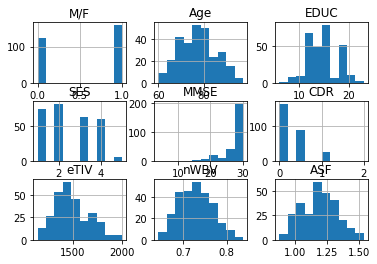

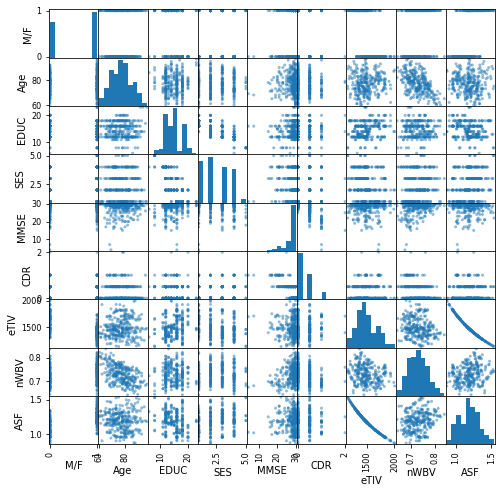

In [5]:
# Basic frequency histograms for each feature. We see MMSE is skewed toward high scores. CDR toward lower.
X_train.hist()

# Scatter matrix of features. eTIV and ASF are closely correlated (ASF is derived from eTIV). Some correlation between age and nWBV,
# which intuitively makes sense.
pd.plotting.scatter_matrix(X_train, figsize=(8,8));

<AxesSubplot:>

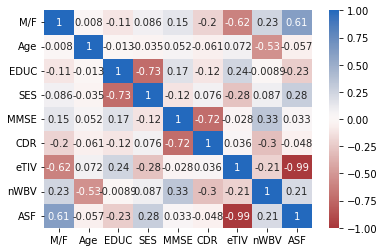

In [6]:
# Pearson correlations with heatmap. Note ASF + gender. SES + Educ. CDR + MMSE. ASF + eTIV.
import seaborn
seaborn.heatmap(X_train.corr(), vmin=-1, vmax=1, cmap="vlag_r", annot=True)

### Examine target

Nondemented    0.536723
Demented       0.463277
Name: Group, dtype: float64


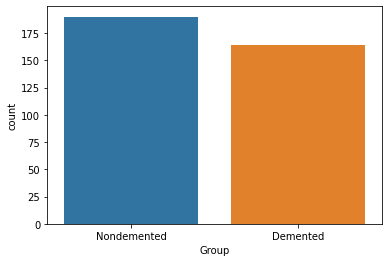

In [7]:
import seaborn as sns
%matplotlib inline

# Transform "Converted" to "Demented" for the pre-split data
y = y.str.replace('Converted', 'Demented')

# Plot the categorical target variable from the pre-split data
sns.countplot(x=y)

# Show frequencies. Each outcome is approximately equally represented.
print(y.value_counts(normalize=True))

### Supervised learning: logistic regression and decision tree classifiers

In [8]:
# First algorithm: Logistic regression
from sklearn.linear_model import LogisticRegression

# Instantiate and fit the LogisticRegression model. When running the Logistic Regression algorithm, I got a 
# convergence error/warning (for lbfgs solver), though it still ran. Default iterations were 100, so I increased to 1000 and
# that resolved the issue, but notably, only after scaling the data. Apparently higher iterations or failing to converge
# reduces the confidence in the prediction and scoring.
logreg = LogisticRegression(max_iter=1000)

# Second algorithm: Decision tree
from sklearn.tree import DecisionTreeClassifier

#Instantiate and fit the Decision Tree Classifier. Set random_state to 2 for reproducibility.
dectree = DecisionTreeClassifier(random_state=2)

### Run and validate models using grid search

In [9]:
# Import tools for cross validation and scoring
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# FIRST, FOR LOGISTIC REGRESSION. Run with the default parameters using cross-validation.
print("Logistic regression scoring metrics using default parameters:")
print("\n\tCross validation scores: {}\n".format(cross_val_score(logreg, X_train, y_train, cv=5)))

# Fit model to scaled training data and predict against the test data.
logreg.fit(X_train_scaled, y_train)
y_pred = logreg.predict(X_test_scaled)

# Calculate precision, recall, F1. Use classification_report to show a table of the metrics.
print(classification_report(y_test, y_pred))

# CANNOT calculate r2, RMSE, and MAE for logistic regression, but can accuracy scores. Note how scaling vastly improved scores.
print("\tAccuracy score on un-scaled training data: {}".format(logreg.score(X_train, y_train)))
print("\tAccuracy score on un-scaled test data: {}".format(logreg.score(X_test, y_test)))
print("\tAccuracy score on SCALED training data: {}".format(logreg.score(X_train_scaled, y_train)))
print("\tAccuracy score on SCALED test data: {}".format(logreg.score(X_test_scaled, y_test)))

# Grid search using the inverse regularization strength C (default = 1).
param_grid = {'C': [0.001, 0.01, 1, 10, 100]}
logregGS = GridSearchCV(logreg, param_grid=param_grid)
logregGS.fit(X_train_scaled, y_train)
print('\n\tBest C from GridSearch: {}'.format(logregGS.best_params_))
print('\tBest score from GridSearch: {}'.format(logregGS.best_score_))

# Note: did not re-run model after Grid Search because best parameter was C = 1, which is the default C for
# sklearn's Logistic Regression.


# SECOND, FOR DECISION TREE CLASSIFIER. Perform cross-validation with default parameters. Use unscaled training data.
print("\n\n\nDecision tree scoring metrics using default parameters:")
print("\n\tCross validation scores: {}\n".format(cross_val_score(dectree, X_train, y_train, cv=5)))

# Fit dectree to training data and predict against the test data (UNSCALED - for decision trees).
dectree.fit(X_train, y_train)
y_pred = dectree.predict(X_test)

# Calculate precision, recall, F1. Use classification_report to show a table of the metrics.
print(classification_report(y_test, y_pred))

# Accuracy scoring.
print("\tAccuracy score on training data: {}".format(dectree.score(X_train, y_train)))
print("\tAccuracy score on test data: {}".format(dectree.score(X_test, y_test)))

# Grid search using DecisionTree parameters of 'criterion,' 'max_depth', and 'max_features'
param_grid = {'criterion': ['entropy', 'gini'], 'max_depth': list(range(1, 9)), 'max_features': list(range(1, 10))}
dectreeGS = GridSearchCV(dectree, param_grid=param_grid)
dectreeGS.fit(X_train, y_train)
print('\n\tBest parameters from GridSearch: {}'.format(dectreeGS.best_params_))
print('\tBest score from GridSearch: {}'.format(dectreeGS.best_score_))

# Re-run the model with the best parameters
dectree_best = DecisionTreeClassifier(criterion = 'entropy', max_depth=5, max_features=8, random_state=2)

dectree_best.fit(X_train, y_train)
y_pred = dectree_best.predict(X_test)

# New classification report
print('\n\nRe-run the model with the best parameters from Grid Search\n')
print(classification_report(y_test, y_pred))

# New accuracy scoring.
print("\tAccuracy score on training data: {}".format(dectree_best.score(X_train, y_train)))
print("\tAccuracy score on test data: {}".format(dectree_best.score(X_test, y_test)))

Logistic regression scoring metrics using default parameters:

	Cross validation scores: [0.9122807  0.94736842 0.94736842 0.94642857 0.89285714]

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        33
           1       0.93      1.00      0.96        38

    accuracy                           0.96        71
   macro avg       0.96      0.95      0.96        71
weighted avg       0.96      0.96      0.96        71

	Accuracy score on un-scaled training data: 0.5371024734982333
	Accuracy score on un-scaled test data: 0.5352112676056338
	Accuracy score on SCALED training data: 0.9399293286219081
	Accuracy score on SCALED test data: 0.9577464788732394

	Best C from GridSearch: {'C': 1}
	Best score from GridSearch: 0.9398496240601505



Decision tree scoring metrics using default parameters:

	Cross validation scores: [0.89473684 0.89473684 0.92982456 0.89285714 0.83928571]

              precision    recall  f1-score   support

      

C:\Users\bpinb\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\bpinb\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(



	Best parameters from GridSearch: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 8}
	Best score from GridSearch: 0.943358395989975


Re-run the model with the best parameters from Grid Search

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        33
           1       0.93      1.00      0.96        38

    accuracy                           0.96        71
   macro avg       0.96      0.95      0.96        71
weighted avg       0.96      0.96      0.96        71

	Accuracy score on training data: 0.9575971731448764
	Accuracy score on test data: 0.9577464788732394


### Try PCA for feature selection

In [10]:
from sklearn.decomposition import PCA

# Perform PCA on scaled training data, explore it.
pca = PCA()
pca.fit(X_train_scaled)

print('---PCA on scaled data---')
print('Number of components: {}'.format(pca.n_components_))
print('Explained variance ratio of each feature: {}'.format(pca.explained_variance_ratio_))

# Use sklearn PCA's built-in function that performs PCA on the number of components explained by a stated 
# variance 0<x<1 (in this case, 0.95, or 95%). Then fit_transform the data.
pca95 = PCA(n_components=0.95)
pca95.fit(X_train_scaled)
print('\n---PCA on scaled data with 95% variance---')
print('Number of features retaining 95% of the variance: {}'.format(pca95.n_components_))

# Use 95% PCA transformed X training data and apply to Logistic Regression (with best parameters [default] from Project 2).
# There is no improvment - the scoring metrics remain the same.
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
pca95_X_train = pca95.transform(X_train_scaled)
logreg.fit(pca95_X_train, y_train)
# Remember to apply PCA to the (scaled) test data too (but don't re-fit it).
pca95_X_test = pca95.transform(X_test_scaled)
y_pred = logreg.predict(pca95_X_test)
print('\n\n Logistic Regression with PCA\n' + classification_report(y_test, y_pred))

# Use 95% PCA transformed X training data and apply to the Decision Tree Classifier (with best parameters from Project 2).
# Here I excluded max_features=8, since this threw up an error because 8 was higher than the number of dimensions of the PCA
# transformed dataset.
from sklearn.tree import DecisionTreeClassifier
dectree_best = DecisionTreeClassifier(criterion = 'entropy', max_depth=5, random_state=2)
dectree_best.fit(pca95_X_train, y_train)
y_pred2 = dectree_best.predict(pca95_X_test)

# Print classification report. This PCA processing actually lowers the scores for the Decision Tree Classifier.
from sklearn.metrics import classification_report
print('\n\n Decision Tree with PCA\n' + classification_report(y_test, y_pred2))

---PCA on scaled data---
Number of components: 9
Explained variance ratio of each feature: [0.31884031 0.23268029 0.1550938  0.14193459 0.05346675 0.03850638
 0.03018848 0.02822425 0.00106515]

---PCA on scaled data with 95% variance---
Number of features retaining 95% of the variance: 7


 Logistic Regression with PCA
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        33
           1       0.93      1.00      0.96        38

    accuracy                           0.96        71
   macro avg       0.96      0.95      0.96        71
weighted avg       0.96      0.96      0.96        71



 Decision Tree with PCA
              precision    recall  f1-score   support

           0       0.88      0.85      0.86        33
           1       0.87      0.89      0.88        38

    accuracy                           0.87        71
   macro avg       0.87      0.87      0.87        71
weighted avg       0.87      0.87      0.87        71


### Try 3 types of clustering and visualize the output, both with and without PCA run first. Calculate both ARI and Silhouette Coefficient for all six of the combinations.

C:\Users\bpinb\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


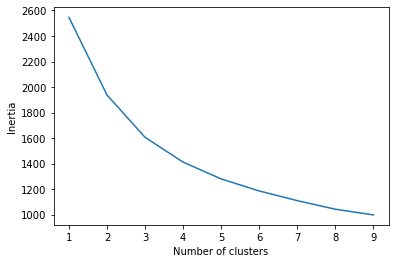

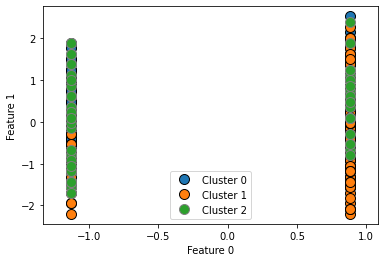

Adjusted rand score: 0.15235632793779366
Silhouette score: 0.24703550406013314


C:\Users\bpinb\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


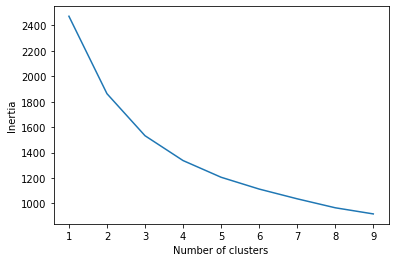

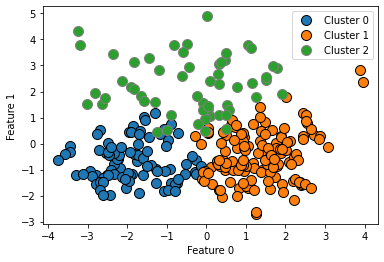

Adjusted rand score: 0.14800218609405966
Silhouette score: 0.2541916483190182


In [11]:
# Kmeans
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import mglearn
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import silhouette_score


# First run with the non-PCA transformed data. Create a dictionary, run through the typical 1-9 k cluster number for 
# kmeans algorithm and add inertia values to dictionary, then plot.
inertiaVals = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k).fit(X_train_scaled)
    inertiaVals[k] = kmeans.inertia_

plt.figure()
plt.plot(list(inertiaVals.keys()), list(inertiaVals.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

# Visualize two features in non-PCA transformed using mglearn. Tried n_clusters = 4, based on elbow plot, but this gave
# a bad ARI and silhouette score. Changed to n_clusters = 3.
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train_scaled)
mglearn.discrete_scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], kmeans.labels_, markers='o')
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

# Calculate ARI and silhouette coefficient.
print("Adjusted rand score: {}".format(adjusted_rand_score(y_train, kmeans.fit_predict(X_train_scaled))))
print("Silhouette score: {}".format(silhouette_score(X_train_scaled, kmeans.fit_predict(X_train_scaled))))


# Run with the PCA transformed training data. No change in elbow plot except inertia scaling is reduced.
inertiaVals2 = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k).fit(pca95_X_train)
    inertiaVals2[k] = kmeans.inertia_

plt.figure()
plt.plot(list(inertiaVals2.keys()), list(inertiaVals2.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

# Visualize two features in PCA transformed data using mglearn. Use n_clusters = 4, based on elbow plot.
kmeans = KMeans(n_clusters=3)
kmeans.fit(pca95_X_train)
mglearn.discrete_scatter(pca95_X_train[:, 0], pca95_X_train[:, 1], kmeans.labels_, markers='o')
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

# Calculate ARI and silhouette coefficient.
print("Adjusted rand score: {}".format(adjusted_rand_score(y_train, kmeans.fit_predict(pca95_X_train))))
print("Silhouette score: {}".format(silhouette_score(pca95_X_train, kmeans.fit_predict(pca95_X_train))))

### Agglomerative

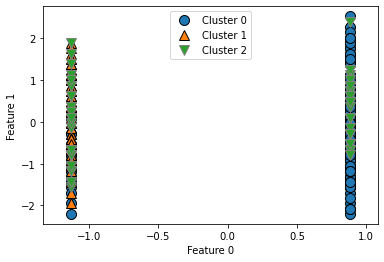

Adjusted rand score: 0.2100585223391841
Silhouette score: 0.2291207384839351


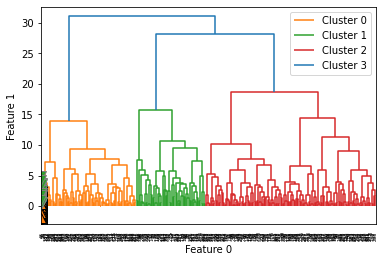

Adjusted rand score: 0.09429353626326827
Silhouette score: 0.23792956704455853


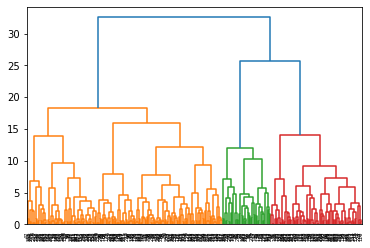

In [12]:
#Agglommerate/Hierarichical
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, ward

# Run with 4 clusters per the previous KMeans elbow. Running with 3 clusters improves ARI and Silhouette to 0.21 and 0.229,
# respectively.
agg = AgglomerativeClustering(n_clusters=3)

# First, non-PCA transformed
agglomClust = agg.fit_predict(X_train_scaled)

mglearn.discrete_scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], agglomClust)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

# Apply the ward clustering to the data array X_train_scaled
# The SciPy ward function returns an array that specifies the distances bridged when performing agglomerative clustering.
linkage_array = ward(X_train_scaled)
# Now we plot the dendrogram for the linkage_array containing the distances between clusters. Note this is a relatively
# qualitative view.
dendrogram(linkage_array);

# Calculate ARI and silhouette coefficient.
print("Adjusted rand score: {}".format(adjusted_rand_score(y_train, agglomClust)))
print("Silhouette score: {}".format(silhouette_score(X_train_scaled, agglomClust)))


# Next, PCA transformed
agglomClust = agg.fit_predict(pca95_X_train)

mglearn.discrete_scatter(pca95_X_train[:, 0], pca95_X_train[:, 1], agglomClust)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

linkage_array = ward(pca95_X_train)
dendrogram(linkage_array);

# Calculate ARI and silhouette coefficient.
print("Adjusted rand score: {}".format(adjusted_rand_score(y_train, agglomClust)))
print("Silhouette score: {}".format(silhouette_score(pca95_X_train, agglomClust)))

### DBSCAN

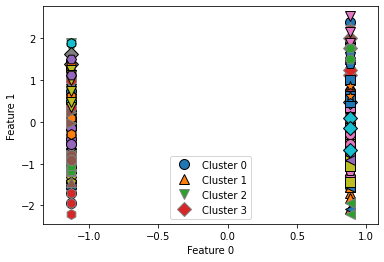

Adjusted rand score: 0.1438000024095892
Silhouette score: 0.12394249337378326


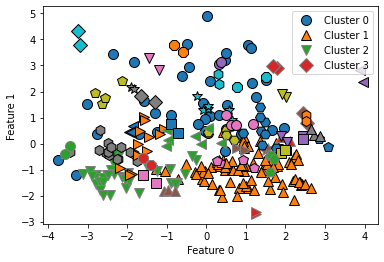

Adjusted rand score: 0.1597012181228285
Silhouette score: 0.11309762757921517


In [13]:
# DBSCAN on non-PCA transformed data
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(min_samples=2, eps=1.3)
clusters = dbscan.fit_predict(X_train_scaled)

mglearn.discrete_scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], clusters)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

# Calculate ARI and silhouette coefficient.
print("Adjusted rand score: {}".format(adjusted_rand_score(y_train, clusters)))
print("Silhouette score: {}".format(silhouette_score(X_train_scaled, clusters)))


# PCA transformed
clusters = dbscan.fit_predict(pca95_X_train)

mglearn.discrete_scatter(pca95_X_train[:, 0], pca95_X_train[:, 1], clusters)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.show()

# Calculate ARI and silhouette coefficient.
print("Adjusted rand score: {}".format(adjusted_rand_score(y_train, clusters)))
print("Silhouette score: {}".format(silhouette_score(pca95_X_train, clusters)))